In [7]:
# --- CELL 1: SETUP & GPU CHECK ---
# Import necessary libraries and configure the hardware device (GPU or CPU).
# Using a GPU is highly recommended for BERT training to drastically reduce time.

import torch
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification
import sys

# Check if NVIDIA GPU is available via CUDA
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU detected: {torch.cuda.get_device_name(0)}")
    print(f"  VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else: 
    device = torch.device("cpu")
    print("GPU not detected! Training will be slow on CPU!")

print(f"Using device: {device}")

GPU detected: NVIDIA GeForce RTX 4060 Laptop GPU
  VRAM: 8.59 GB
Using device: cuda


In [8]:
# --- CELL 2: LOAD DATA & MINIMAL CLEANING ---
# Load datasets, apply minimal cleaning (preserving stopwords/punctuation for BERT context),
# and split data into training and validation sets.

import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split

INPUT_FILE = "../data/news_dataset.csv"

try: 
    # Load raw data
    print(f"Loading dataset from {INPUT_FILE}...")
    df = pd.read_csv(INPUT_FILE)

    # Remove missing values
    df = df.dropna(subset=['text', 'title'])

    # Shuffle the dataset
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    print("Datasets were loaded successfully!")
    print(f"  Total articles: {df.shape[0]}")
    print(f"  Class Balance (0=Fake, 1=Real):\n{df['labels'].value_counts()}")

except FileNotFoundError:
    print("ERROR: Could not find  in ../data/")

# Minimal cleaning function for BERT
def clean_text(text):
    text = str(text).lower()

    # --- ANTI-BIAS CLEANING  ---
    # Remove patterns like "washington (reuters) -" from the start
    text = re.sub(r'^.*?\s\(reuters\)\s-\s', '', text)
    # Remove standalone agency names
    text = re.sub(r'\b(reuters|bbc|cnn|ap|united press international)\b', '', text)

    # Remove media tags (VIDEO), [VIDEO], (IMAGE), [JPG], etc.
    text = re.sub(r'[\(\[]\s*(video|image|img|photos?|watch).*?[\)\]]', '', text)

    # Remove "WATCH:" or "IMAGE:" often found at start of fake news
    text = re.sub(r'^(watch|image|video)\s?:\s?', '', text)

    # Remove URLs (http/https/www)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove blank spaces 
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

print("Starting text cleaning process... (This may take 1-2 minutes).")
df['full_text'] = df['title'] + " " + df['text']
df['clean_text'] = df['full_text'].apply(clean_text)

X = df['clean_text'].values
y = df['labels'].values

# Split data: 80% Training, 20% Validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Data prepared!")
print(f"  Training Examples: {len(X_train)}")
print(f"  Validation Examples: {len(X_val)}")


Loading dataset from ../data/news_dataset.csv...
Datasets were loaded successfully!
  Total articles: 73018
  Class Balance (0=Fake, 1=Real):
labels
0    36509
1    36509
Name: count, dtype: int64
Starting text cleaning process... (This may take 1-2 minutes).
Data prepared!
  Training Examples: 58414
  Validation Examples: 14604


In [9]:
# --- CELL 3: TOKENIZATION & DATASET CLASS ---
# Initialize the BERT tokenizer, define a custom PyTorch Dataset class to format 
# the text data (padding, truncation), and create DataLoaders for batch processing.

from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
import torch
import os

MAX_LEN = 256 # Token limit (Based on the 600 character cutoff in the merger notebook)
BATCH_SIZE = 32 # works for my GPU with 8GB VRAM

print("Downloading Tokenizer...")
# Load the BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class NewsDataset(Dataset):
    """Custom Dataset class to handle tokenization and tensor conversion."""
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        # Tokenize the text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        # Return the necessary inputs for BERT as PyTorch tensors
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }
    
print("Creating DataLoaders...")
train_ds = NewsDataset(X_train, y_train, tokenizer, max_len=MAX_LEN)
val_ds = NewsDataset(X_val, y_val, tokenizer, max_len=MAX_LEN)

# Windows optimization
NUM_WORKERS = 0 if os.name == 'nt' else 2

# DataLoaders handle shuffling and feeding data to the GPU in batches
train_loader = DataLoader(
    train_ds, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=NUM_WORKERS, 
)

val_loader = DataLoader(
    val_ds, 
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)

print(f"DataLoader Ready! Max Len: {MAX_LEN} | Batch Size: {BATCH_SIZE}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Training Batches: {len(train_loader)}")

Creating DataLoaders...
DataLoader Ready! Max Len: 256 | Batch Size: 32
  Batch Size: 32
  Training Batches: 1826


In [10]:
# --- CELL 4: INITIALIZE MODEL ---
# Load the pre-trained BERT model architecture and weights, configure it for 
# binary classification, and move it to the GPU for accelerated training.

from transformers import BertForSequenceClassification
from torch.optim import AdamW

print("Downloading Pre-trained BERT Model...")

# Load the pre-trained model
# "bert-base-uncased" must match the tokenizer used earlier
# num_labels=2 sets up the final layer for binary classification (Fake vs Real)
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels=2
)

# Move the model to the GPU
model.to(device)

print("-" * 30)
print("Model loaded successfully!")
print(f"Model moved to device: {device}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


------------------------------
Model loaded successfully!
Model moved to device: cuda


In [11]:
# --- CELL 5: TRAINING LOOP ---
# Define the optimizer, the training function, and execute the training loop over multiple epochs.

import time
import torch

# Initialize AdamW optimizer (standard for BERT) with a specific learning rate
optimizer = AdamW(model.parameters(), lr=3e-5)

def train_epoch(model, data_loader, optimizer, device, epoch_idx):
    model.train()

    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    print(f"\n --- START EPOCH {epoch_idx+1}/{EPOCHS} ---")

    for batch_idx, batch in enumerate(data_loader):
        # Move batch data to the GPU
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass: get model predictions and calculate loss
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        # Backward pass: Zero gradients -> Calculate gradients -> Update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track statistics
        total_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        total_predictions += labels.size(0)

        # Log progress every 50 batches
        if (batch_idx % 50 == 0 and batch_idx > 0):
            print(f"Batch {batch_idx}/{len(data_loader)} | Current Loss: {loss.item():.4f}")
    
    # Calculate average metrics for the epoch
    avg_loss = total_loss / len(data_loader)
    epoch_acc = correct_predictions.double() / total_predictions

    print(f"FINISHED EPOCH {epoch_idx+1}")
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Accuracy: {epoch_acc:.4f} ({(epoch_acc*100):.2f}%)")


# Start the training process
EPOCHS = 2
total_t0 = time.time()

for epoch in range(EPOCHS):
    start_time = time.time()
    train_epoch(model, train_loader, optimizer, device, epoch)
    print(f"Time for epoch: {(time.time() - start_time):.1f} seconds")

print("\nTRAINING COMPLETE!")
print(f"Total Training Time: {(time.time() - total_t0):.1f} seconds")


 --- START EPOCH 1/2 ---
Batch 50/1826 | Current Loss: 0.1845
Batch 100/1826 | Current Loss: 0.1469
Batch 150/1826 | Current Loss: 0.0181
Batch 200/1826 | Current Loss: 0.0072
Batch 250/1826 | Current Loss: 0.0328
Batch 300/1826 | Current Loss: 0.1056
Batch 350/1826 | Current Loss: 0.0896
Batch 400/1826 | Current Loss: 0.1458
Batch 450/1826 | Current Loss: 0.1255
Batch 500/1826 | Current Loss: 0.0172
Batch 550/1826 | Current Loss: 0.0823
Batch 600/1826 | Current Loss: 0.1043
Batch 650/1826 | Current Loss: 0.0327
Batch 700/1826 | Current Loss: 0.0018
Batch 750/1826 | Current Loss: 0.0041
Batch 800/1826 | Current Loss: 0.0084
Batch 850/1826 | Current Loss: 0.1599
Batch 900/1826 | Current Loss: 0.0671
Batch 950/1826 | Current Loss: 0.0360
Batch 1000/1826 | Current Loss: 0.2494
Batch 1050/1826 | Current Loss: 0.0165
Batch 1100/1826 | Current Loss: 0.0118
Batch 1150/1826 | Current Loss: 0.0638
Batch 1200/1826 | Current Loss: 0.0440
Batch 1250/1826 | Current Loss: 0.0653
Batch 1300/1826 | C

In [12]:
# --- CELL 6: SAVE TRAINED MODEL ---
# Save the fine-tuned BERT model and its tokenizer to a specified directory.
# This allows loading the model later for inference without retraining.

import os

output_dir = '../models/bert_model'

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print(f"Saving model to {output_dir}...")

# Handle multi-GPU cases (DataParallel) to ensure we save the underlying model correctly
model_to_save = model.module if hasattr(model, 'module') else model
# Save model weights and configuration
model_to_save.save_pretrained(output_dir)
# Save tokenizer vocabulary and configuration
tokenizer.save_pretrained(output_dir)

print("Model saved successfully!")

Saving model to ../models/bert_model...
Model saved successfully!


Loading model from: ../models/bert_model...
Model loaded successfully from disk!
Running predictions on Validation Set...

FINAL BERT PERFORMANCE REPORT
              precision    recall  f1-score   support

   Fake News       0.99      0.99      0.99      7302
   Real News       0.99      0.99      0.99      7302

    accuracy                           0.99     14604
   macro avg       0.99      0.99      0.99     14604
weighted avg       0.99      0.99      0.99     14604



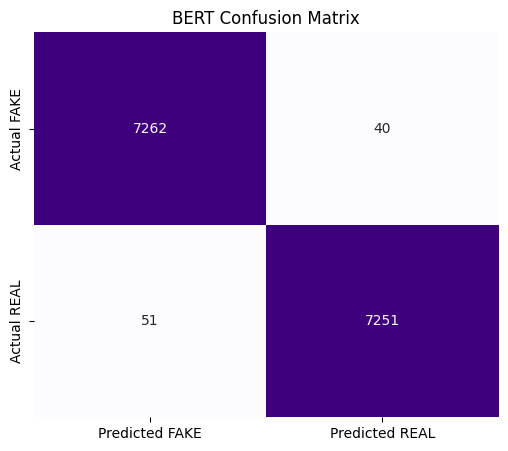

In [13]:
# --- CELL 7: FINAL EVALUATION (LOAD FROM DISK) ---
# Load the saved model from disk to verify integrity, run predictions on the validation set, 
# and generate a final performance report (Precision, Recall, F1) and Confusion Matrix.

import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertForSequenceClassification

saved_model_path = '../models/bert_model'

print(f"Loading model from: {saved_model_path}...")

try:
    # Load the fine-tuned model weights from the saved directory
    loaded_model = BertForSequenceClassification.from_pretrained(saved_model_path)
    
    # Move to GPU and set to evaluation mode (disables Dropout)
    loaded_model.to(device)
    loaded_model.eval()
    
    print("Model loaded successfully from disk!")

    print("Running predictions on Validation Set...")
    all_preds = []
    all_labels = []

    # Disable gradient calculation for inference (saves memory)
    with torch.no_grad():
        for batch in val_loader:
            # Move batch to GPU
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Get model predictions
            outputs = loaded_model(input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)
            
            # Store predictions and true labels on CPU
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\n" + "="*50)
    print("FINAL BERT PERFORMANCE REPORT")
    print("="*50)
    # Print detailed metrics
    print(classification_report(all_labels, all_preds, target_names=['Fake News', 'Real News']))

    # Plot Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=False,
                xticklabels=['Predicted FAKE', 'Predicted REAL'],
                yticklabels=['Actual FAKE', 'Actual REAL'])
    plt.title('BERT Confusion Matrix')
    plt.show()

except OSError:
    print(f"ERROR: Could not find model at '{saved_model_path}'.")

GPU Detected: NVIDIA GeForce RTX 4060 Laptop GPU
Loading Saved Model...
Model loaded successfully!
Loading Dataset...
Dataset loaded: 73018 articles available.
--------------------------------------------------
Selected Article ID: 49280
True Label: FAKE NEWS
--------------------------------------------------
CONTENT PREVIEW:
 Cliven Bundy Takes Charge Of Remaining Oregon Militiamen, Says They Will Continue Occupation Indefinitely. With his son Ammon Bundy in jail with most of the the militants who had been occupying the Malheur Wildlife Refuge in Harney County, Oregon, Cliven Bundy has decided to take matters into his own hands. In a letter addressed to the authorities responsible for the arrests of many of the milita...
--------------------------------------------------
Generating explanation (this may take a moment)...
Model Prediction:
Fake: 99.94% | Real: 0.06%


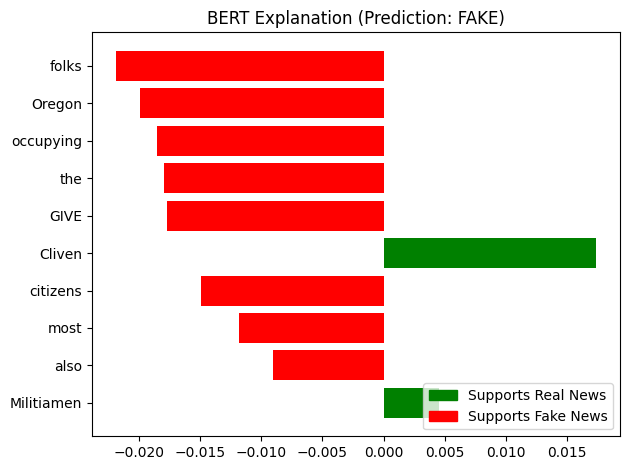

In [17]:
# --- CELL 8: LIME ON RANDOM TEST DATA ---
# Loads the dataset, picks a random article, and explains the model's prediction.

from lime.lime_text import LimeTextExplainer
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import re
import random

# SETUP DEVICE
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU Detected: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

# LOAD SAVED MODEL
print("Loading Saved Model...")
model_path = '../models/bert_model'

try:
    tokenizer = BertTokenizer.from_pretrained(model_path)
    model = BertForSequenceClassification.from_pretrained(model_path)
    model.to(device)
    model.eval()
    print("Model loaded successfully!")
except OSError:
    print("ERROR: Could not find the model. Please run the training cell first.")

# LOAD DATASET (To pick a random sample)
print("Loading Dataset...")
try:
    df = pd.read_csv("../data/news_dataset.csv")
    df = df.dropna(subset=['text'])
    
    print(f"Dataset loaded: {len(df)} articles available.")

except FileNotFoundError:
    print("ERROR: Could not find 'news_dataset.csv'. Run 'Merging_Datasets.ipynb' first!")

# CLEANING FUNCTION
# Needs to be identical to the one used during training
def clean_text(text):
    text = str(text).lower()

    # --- ANTI-BIAS CLEANING  ---
    # Remove patterns like "washington (reuters) -" from the start
    text = re.sub(r'^.*?\s\(reuters\)\s-\s', '', text)
    # Remove standalone agency names
    text = re.sub(r'\b(reuters|bbc|cnn|ap|united press international)\b', '', text)

    # Remove media tags (VIDEO), [VIDEO], (IMAGE), [JPG], etc.
    text = re.sub(r'[\(\[]\s*(video|image|img|photos?|watch).*?[\)\]]', '', text)

    # Remove "WATCH:" or "IMAGE:" often found at start of fake news
    text = re.sub(r'^(watch|image|video)\s?:\s?', '', text)

    # Remove URLs (http/https/www)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove blank spaces 
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# PREDICTION WRAPPER (With Cleaning & Batching)
# LIME passes raw text. We must clean it before sending to BERT.
def predict_proba(text_list):
    preds = []
    BATCH_SIZE = 8
    
    for i in range(0, len(text_list), BATCH_SIZE):
        batch_raw = text_list[i : i + BATCH_SIZE]
        
        # Apply cleaning to the batch
        batch_clean = [clean_text(t) for t in batch_raw]
        
        # Tokenize
        encoded = tokenizer(
            batch_clean, 
            padding=True, 
            truncation=True, 
            max_length=256, 
            return_tensors='pt'
        )
        
        input_ids = encoded['input_ids'].to(device)
        attention_mask = encoded['attention_mask'].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            probs = F.softmax(outputs.logits, dim=1)
            preds.extend(probs.cpu().numpy())
            
        del input_ids, attention_mask, outputs, probs
        torch.cuda.empty_cache()
            
    return np.array(preds)

# PICK RANDOM SAMPLE
random_idx = random.randint(0, len(df) - 1)
row = df.iloc[random_idx]

# Combine Title + Text for full context
raw_text = str(row['title']) + ". " + str(row['text'])
true_label = row['labels']
label_str = "REAL NEWS" if true_label == 1 else "FAKE NEWS"

print("-" * 50)
print(f"Selected Article ID: {random_idx}")
print(f"True Label: {label_str}")
print("-" * 50)
print(f"CONTENT PREVIEW:\n{raw_text[:400]}...") 
print("-" * 50)

# GENERATE EXPLANATION
print("Generating explanation (this may take a moment)...")

explainer = LimeTextExplainer(class_names=['Fake News', 'Real News'])

try:
    # We pass the RAW text to LIME so the visualization is readable.
    # The predict_proba function handles the cleaning internally.
    exp = explainer.explain_instance(
        raw_text,
        predict_proba, 
        num_features=10,
        num_samples=500 
    )
    
    # Get prediction probabilities
    probs = predict_proba([raw_text])[0]
    fake_prob, real_prob = probs[0], probs[1]
    
    print(f"Model Prediction:")
    print(f"Fake: {fake_prob:.2%} | Real: {real_prob:.2%}")

    # Plot
    fig = exp.as_pyplot_figure()
    green_patch = mpatches.Patch(color='green', label='Supports Real News')
    red_patch = mpatches.Patch(color='red', label='Supports Fake News')
    plt.legend(handles=[green_patch, red_patch], loc='lower right')
    
    pred_label = 'REAL' if real_prob > fake_prob else 'FAKE'
    plt.title(f"BERT Explanation (Prediction: {pred_label})")
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")